# Week 7 Problem 3

If you are not using the `Assignments` tab on the course JupyterHub server to read this notebook, read [Activating the assignments tab](https://github.com/UI-DataScience/info490-fa16/blob/master/Week2/assignments/README.md).

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do **not** write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select _Kernel_, and restart the kernel and run all cells (_Restart & Run all_).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select _File_ → _Save and CheckPoint_)

5. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

In [1]:
%matplotlib inline

# plotting tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")

# testing tools
from nose.tools import assert_equal, assert_is_instance, assert_is_not
from numpy.testing import assert_array_equal

# Problem 1. Distance vs. Flight Time

In this problem, we are going to use the 2001 [airline on-time performance data](http://stat-computing.org/dataexpo/2009/the-data.html) `2001.csv`, which is located in the `data` folder under our home directory, to create a scatter plot of `Distance` vs. `ActualElapsedTime`. `~/data/2001.csv` is a large CSV file which contains as many as 5967781 lines:

```python
!cat ~/data/2001.csv | wc -l
```
    5967781

That is to say, if we plot two columns in `2001.csv`, we are going to plot over 5 million points. Trying to plot all 5 million points in one scatter plot will result in waiting forever to process the plot, an IPython notebook with a very large file size, and an extremely cluttered plot. We certainly do not want to do that. Instead, we can plot every *n*-th point. Suppose we want to plot every 1000-th point, we could extract every 1000-th line from the `2001.csv` file. The code cell below copies the header and every 1000-th line from `2001.csv` to the `~/w7p3/` directory and displays the first 10 rows of the output file. In this problem, we are going to work with `~/w7p3/2001.csv`.

In [2]:
# make a directory for week 7 problem 3
!mkdir -p ~/w7p3/ 

# get every 1000-th line in the original 2001.csv file, keeping header
!sed -n '1p;0~1000p' ~/data/2001.csv >~/w7p3/2001.csv 

!head ~/w7p3/2001.csv

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2001,1,11,4,2205,2215,2255,2315,US,416,N514A�,50,60,33,-20,-10,PIT,IAD,183,6,11,0,NA,0,NA,NA,NA,NA,NA
2001,1,3,3,753,745,841,838,US,446,N891��,48,53,37,3,8,PIT,BUF,186,3,8,0,NA,0,NA,NA,NA,NA,NA
2001,1,25,4,716,720,828,839,US,479,N122��,72,79,57,-11,-4,RDU,PHL,336,4,11,0,NA,0,NA,NA,NA,NA,NA
2001,1,8,1,1342,1340,1518,1519,US,507,N606A�,96,99,82,-1,2,CLT,TPA,508,4,10,0,NA,0,NA,NA,NA,NA,NA
2001,1,20,6,NA,1330,NA,1433,US,534,�NKNO�,NA,123,NA,NA,NA,CLT,STL,575,0,0,1,NA,0,NA,NA,NA,NA,NA
2001,1,6,6,951,945,1134,1128,US,566,N340��,103,103,74,6,6,CLT,IND,428,7,22,0,NA,0,NA,NA,NA,NA,NA
2001,1,28,7,1515,1520,1627,1640,US,603,N765��,72,80,57,-13,-5,RDU,PIT,328,7,8,0,NA,0,NA,NA,NA,NA,NA
2001,1,7,7,1110,11

## 1. Function: get_columns()

In the following code cell, modify the `get_column()` function from [Problem 5.2](https://github.com/UI-DataScience/info490-fa16/blob/master/Week5/assignments/Problem_2.ipynb) to create a new function named `get_columns()`:

- `get_columns(filepath, n1, n2, header=True)` reads the n1-th column and the n2-th column from a file and returns a tuple of two integer lists in the order specified by n1 and n2.
- You may assume that the column is made of integers, i.e. the strings you extracted from the file can be converted to integers.
- `header` is an optional argument. If it is `True`, skip the first row; if it is `False`, do not skip.
- You have to specify that the encoding is `latin-1`, e.g.
  ```python
  open(filepath, encoding='latin-1')
  ```
- I call the first argument as `filepath` to make it more clear, since we are going to work with a file that is not in the same directory as this notebook.
- If a row in either of the two columns contains the missing value `"NA"`, skip that row for **both** columns. That is to say, the two output columns should have the **same** length, so that our scatter plot in the next step will not be messed up. 
- In addition to the traditional input method mentioned in the [Week 5 Lesson 2 notebook](https://github.com/UI-DataScience/info490-fa16/blob/master/Week5/notebooks/pyfileio.ipynb), you could also try [csv module](https://docs.python.org/3/library/csv.html), [numpy.genfromtxt()](http://docs.scipy.org/doc/numpy/user/basics.io.genfromtxt.html), [numpy.loadtxt()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html), or [Pandas read_csv()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html). 
- Depending on which method you choose to use, you may want to handle `"NA"` during you read the file, or remove `"NA"` after you construct the two columns. 

In [3]:
def get_columns(filepath, n1, n2, header=True):
    '''
    Returns two integer lists from reading the specified two columns in the CSV file.

    Parameters
    __________
    filepath (str): Input file path. The file is assumed to be in a 
                    Comma Separated Values (CSV) format with latin-1 encoding.
    n1 (int): Column number. The first column starts at 0. The column must be
             a list of integers.
    n2 (int): Another column number.
    '''
    
    # Create two empty lists to contain extracted columns from the file
    list1 = []
    list2 = []

    with open (filepath, 'r', encoding = 'latin-1') as f:
        if header:
            # If header is True, then we will skip the first line in the file. 
            next(f, None) 
        for line in f:
            # Split the line into a list
            cols = line.split(',') 
            # Judge whether missing values exist
            if cols[n1] == 'NA' or cols[n2] == 'NA' or cols[n1] == 'NA\n' or cols[n2] == 'NA\n':   
                # Ignore the rows with "NA" or "NA\n" 
                # Because some missing values in the last columns will carry "\n", which means starting a new line.  
                continue 
            else:
                # Append the extracted columns to empty lists
                list1.append(int(cols[n1]))
                list2.append(int(cols[n2]))
                
    return (list1,list2)

In [4]:
# construct csv files for assertion tests
csv_with_header = '''
Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2001,1,17,3,1806,1810,1931,1934,US,375,N700äæ,85,84,60,-3,-4,BWI,CLT,361,5,20,0,NA,0,NA,NA,NA,NA,1
2001,1,18,4,1805,1810,1938,1934,US,375,N713äæ,93,84,64,4,-5,BWI,CLT,361,9,20,0,NA,0,NA,NA,NA,NA,1
2001,1,19,5,1821,1810,1957,1934,US,375,N702äæ,96,84,80,23,11,BWI,CLT,361,6,10,0,NA,0,NA,NA,NA,NA,NA
2001,1,20,6,1807,1810,1944,1934,US,375,N701äæ,97,84,66,10,-3,BWI,CLT,361,4,27,0,NA,0,NA,NA,NA,NA,NA
'''.strip().encode('latin-1')

csv_no_header = '''
2001,1,17,3,1806,1810,1931,1934,US,375,N700äæ,85,84,60,-3,-4,BWI,CLT,361,5,20,0,NA,0,NA,NA,NA,NA,1
2001,1,18,4,1805,1810,1938,1934,US,375,N713äæ,93,84,64,4,-5,BWI,CLT,361,9,20,0,NA,0,NA,NA,NA,NA,1
2001,1,19,5,1821,1810,1957,1934,US,375,N702äæ,96,84,80,23,11,BWI,CLT,361,6,10,0,NA,0,NA,NA,NA,NA,NA
2001,1,20,6,1807,1810,1944,1934,US,375,N701äæ,97,84,66,10,-3,BWI,CLT,361,4,27,0,NA,0,NA,NA,NA,NA,NA
2001,1,21,7,1810,1810,1954,1934,US,375,N768äæ,104,84,62,20,0,BWI,CLT,361,4,38,0,NA,0,NA,NA,NA,NA,1
'''.strip().encode('latin-1')

with open('/home/data_scientist/w7p3/test.header.csv', 'wb') as f:
    f.write(csv_with_header)
    
with open('/home/data_scientist/w7p3/test.noheader.csv', 'wb') as f:
    f.write(csv_no_header)

In [5]:
# assertions for header=True
assert_equal(get_columns('/home/data_scientist/w7p3/test.header.csv', 1, 2, header=True), ([1]*4, list(range(17, 21))))
assert_equal(get_columns('/home/data_scientist/w7p3/test.header.csv', 4, 28, header=True), ([1806, 1805], [1]*2))
assert_equal(get_columns('/home/data_scientist/w7p3/test.header.csv', 3, 27, header=True), ([], []))
assert_equal(get_columns('/home/data_scientist/w7p3/test.header.csv', 0, 12, header=True), ([2001]*4, [84]*4))

# assertions for header=False
assert_equal(get_columns('/home/data_scientist/w7p3/test.noheader.csv', 1, 2, header=False), ([1]*5, list(range(17, 22))))
assert_equal(get_columns('/home/data_scientist/w7p3/test.noheader.csv', 4, 28, header=False), ([1806, 1805, 1810], [1]*3))
assert_equal(get_columns('/home/data_scientist/w7p3/test.noheader.csv', 3, 27, header=False), ([], []))
assert_equal(get_columns('/home/data_scientist/w7p3/test.noheader.csv', 0, 12, header=False), ([2001]*5, [84]*5))

Now that we have the `get_columns()` function, let's get the two columns we will use to make the scatter plot. In the following code cell, apply `get_columns()` to extract the `Distance` and `ActualElapsedTime` columns from  `home/data_scientist/w7p3/2001.csv` and name the two columns as `distance` and `time`.

In [6]:
# The Distance and ActualElapsedTime are respectively located in the 18th and 11th columns
# Get the extracted columns from the file as two variables distance and time
distance, time = get_columns('/home/data_scientist/w7p3/2001.csv',18, 11)

In [7]:
# assertions
assert_equal(len(distance), 5720)
assert_equal(len(time), 5720)
assert_equal(distance[:20], [183, 186, 336, 508, 428, 328, 590, 325, 331, 813, 546, 678, 298, 280, 678, 966, 130, 675, 279, 599])
assert_equal(distance[5700:], [643, 667, 781, 316, 1628, 1035, 406, 1199, 1547, 110, 874, 270, 1587, 272, 932, 745, 2116, 190, 761, 547])
assert_equal(time[:20], [50, 48, 72, 96, 103, 72, 106, 78, 66, 175, 93, 141, 81, 86, 128, 204, 48, 126, 66, 100])
assert_equal(time[5700:], [104, 143, 132, 70, 230, 153, 99, 165, 212, 57, 127, 64, 244, 71, 138, 146, 261, 63, 174, 105])

## 2. Function: make_scatter_plot():

In the following code cell, write a function named `make_scatter_plot()` that creates a two-dimensional scatter plot given two lists, `x` and `y` and returns an `Axes` object.

- The code for creating a `Figure` object and an `Axes` object is already provided:
```python
fig, ax = plt.subplots()
```
- `make_scatter_plot()` returns an instance of the `Axes` object (named `ax`). You should use `ax` to create your plot (check out the [lesson notebook on Python Plotting](https://github.com/UI-DataScience/info490-fa16/blob/master/Week7/notebooks/info490w7l3.ipynb). We write our function to return an `Axes` instance because we want to use it for assertion tests.
- Your plot should have a title and axis labels corresponding to the distance vs. time problem.

In [8]:
def make_scatter_plot(x, y):
    """
    Creates a two-dimensional scatter plot.
    
    Parameters
    ----------
    x: A list of integers. Data points for the x-axis.
    y: A list of integers. Data poitns for the y-axis.
    
    Returns
    -------
    A matplotlib.Axes object.
    """
    
    fig, ax = plt.subplots()
    
    # Plot the scatter plot
    ax.scatter(x, y)
    
    # Set our title
    ax.set_title('distance vs. time')
    
    # Set our axis labels
    ax.set_xlabel('time')
    ax.set_ylabel('distance')

    return ax

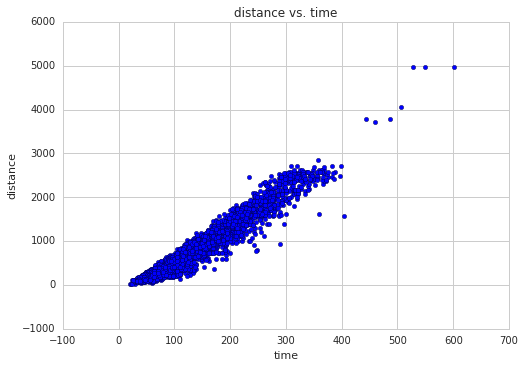

In [9]:
# use the function to make the distance vs. time plot
ax = make_scatter_plot(time, distance)

In [10]:
# assertions
assert_is_instance(
    ax, mpl.axes.Axes,
    msg="Your function should return a matplotlib.axes.Axes object."
)

assert_equal(
    len(ax.collections), 1,
    msg="Your plot does not have any data points."
)

assert_is_not(
    len(ax.title.get_text()), 0,
    msg="Your plot doesn't have a title."
)
assert_is_not(
    ax.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive."
)
assert_is_not(
    ax.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive."
)
    
xdata, ydata = ax.collections[0].get_offsets().T
assert_array_equal(xdata, time)
assert_array_equal(ydata, distance)

# If your function can only plot the delays and
# cannot handle other data sets, the following test will fail.
x1 = np.random.randint(100, size=100)
y1 = np.random.randint(100, size=100)

ax1 = make_scatter_plot(x1, y1)

x1data, y1data = ax1.collections[0].get_offsets().T
assert_array_equal(x1, x1data)
assert_array_equal(y1, y1data)

plt.close()

## Clean up

In [11]:
!rm -rf ~/w7p3